In [1]:
import time
from qutip import *

import numpy as np
from numpy import pi as pi
from numpy import sqrt as sqrt
from numpy import cos as cos
from numpy import sin as sin

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, animation

import sympy
import scipy.linalg as sl

In [2]:
def pulse(t, t0, width):
    return np.where( (t0<t) & (t<(width+t0)), 1, 0)

In [12]:
Su = basis(2,0)
Sd = basis(2,1)
Iu = basis(2,0)
Id = basis(2,1)

Sx = sigmax()
Sy = sigmay()
Sz = (sigmaz() - qeye(2))/2
Sm, Sp = Sx.eigenstates()[1]

Ix = sigmax()
Iy = sigmay()
Iz = sigmaz()
Im, Ip = Ix.eigenstates()[1]

8096


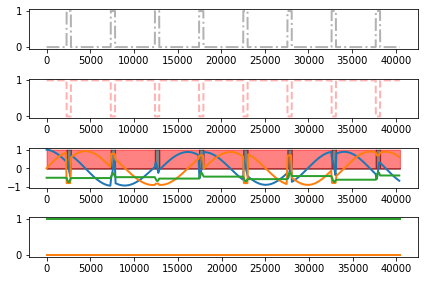

In [13]:
gamma_n = 10.7e-3 * 2*pi
gamma_e = 28 * 2*pi
B = 300e-4
w_L_I = gamma_n * B

theta = pi/2
w_HF = 2*pi*80e-6
A_perp = cos(theta)*w_HF
A_para = sin(theta)*w_HF

N = 8

w_L_S = gamma_e * B
H0 = w_L_S/2 * tensor(Sz, qeye(2)) + w_L_I/2 * tensor(qeye(2), Iz)
HHF = A_para * tensor(Sz, Iz) + A_perp * tensor(Sz, Ix)
HSys = H0 + HHF

T = 500
Omega_pi = pi/T
tau = 2.28e3
N = 4

Hpi = Omega_pi/2*tensor(Sy, qeye(2))
Htau = HSys

dt = T/100
t_block = np.arange(0, (2*T + 4*tau), dt)
pi_block =  pulse(t_block, tau, T) + pulse(t_block, 3*tau+T, T)
tau_block = np.where(pi_block==1, 0, 1)

pi_seq = pi_block.copy()
tau_seq = tau_block.copy()
for i in range(1, N):
    pi_seq = np.append(pi_seq, pi_block)
    tau_seq = np.append(tau_seq, tau_block)
t_seq = np.arange(0, N*(2*T + 4*tau), dt)
print(len(t_seq))

fig, axs = plt.subplots(4, 1)
axs[0].plot(t_seq, pi_seq, alpha=0.3, color='k', ls='-.', lw=2)
axs[1].plot(t_seq, tau_seq, alpha=0.3, color='r', ls='--', lw=2)

rho0 = tensor(Sp*Sp.dag(), Iu*Iu.dag())
output = mesolve([[HSys, tau_seq], [Hpi, pi_seq]], rho0, t_seq, e_ops = [
    tensor(Sx, qeye(2)), 
    tensor(Sy.dag(), qeye(2)), 
    tensor(Sz.dag(), qeye(2)),
    tensor(qeye(2), Ix),
    tensor(qeye(2), Iy),
    tensor(qeye(2), Iz)])

for exp in output.expect[:-3]:
    axs[2].plot(t_seq[::20], exp[::20], ls='-', lw=2)
    axs[2].fill_between(t_seq, 0, pi_seq, color='k', alpha=0.2)    
    axs[2].fill_between(t_seq, 0, tau_seq, color='r', alpha=0.2)

for exp in output.expect[3:]:
    axs[3].plot(t_seq[::20], exp[::20], ls='-', lw=2)
    
plt.tight_layout()

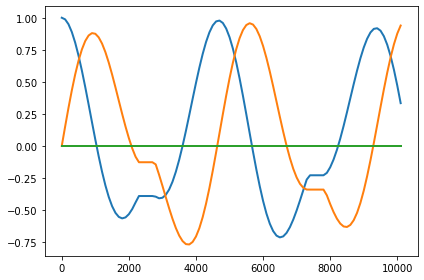

In [14]:
rho0 = tensor(Sp*Sp.dag(), Ip*Ip.dag())
output = mesolve([[HSys, tau_block], [Hpi, pi_block]], rho0, t_block, e_ops = [
    tensor(qeye(2), Ix),
    tensor(qeye(2), Iy),
    tensor(qeye(2), Iz)])

for exp in output.expect:
    plt.plot(t_block[::20], exp[::20], ls='-', lw=2)
    
plt.tight_layout()

C:\Users\Marco\AppData\Local\Temp\ipykernel_22908\2270137226.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, azim=-40, elev=30)


71.4150538444519


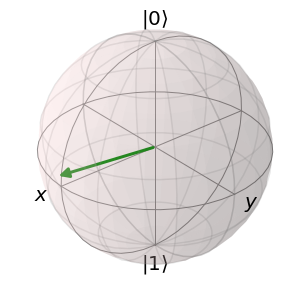

In [134]:
fig = plt.figure()
ax = Axes3D(fig, azim=-40, elev=30)
sphere = qutip.Bloch(axes=ax)

def animate(i):
    sphere.clear()
    sphere.add_vectors([output.expect[0][i], output.expect[1][i], output.expect[2][i]])
    sphere.make_sphere()
    return ax

t = time.time()
ani = animation.FuncAnimation(fig, animate, np.arange(len(output.expect[0])), blit=False, repeat=False)
ani.save('bloch_sphere.gif', fps=60)
print(time.time() - t)

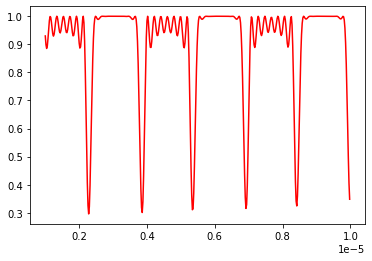

In [31]:
mu_I = 10.7e6 * 2*pi
B = 300e-4
w_L = mu_I * B
w_h = 2*pi*80e3
theta = pi/2
N = 8

def phi(tau, w_L, w_h, theta):
    A = w_h*np.cos(theta)
    B = w_h*np.sin(theta)    
    w_tilde = sqrt((A+w_L)**2 + B**2)
    m_x = B/w_tilde
    m_z = (A+w_L)/w_tilde
    
    alpha = w_tilde*tau    
    beta = w_L*tau
    
    phi = np.arccos(np.cos(alpha)*np.cos(beta) - m_z*np.sin(alpha)*np.sin(beta))
    return phi

def n1n2(tau, w_L, w_h, theta):
    A = w_h*np.cos(theta)
    B = w_h*np.sin(theta)    
    w_tilde = sqrt((A+w_L)**2 + B**2)
    m_x = B/w_tilde
    m_z = (A+w_L)/w_tilde
    
    alpha = w_tilde*tau    
    beta = w_L*tau
    
    return -m_x**2*(1-np.cos(alpha))*(1-np.cos(beta))/(1 + np.cos(alpha)*np.cos(beta) - m_z*np.sin(alpha)*np.sin(beta)) + 1

def M(n1n2_, phi_, N):
    return 1-(1-n1n2_)*np.sin(N*phi_/2)**2

def Px(M_):
    return (M_+1)/2

taus = np.arange(1, 10, 0.02)*1e-6
phi_ = phi(taus, w_L, w_h, theta)
n1n2_ = n1n2(taus, w_L, w_h, theta)
M_ = M(n1n2_, phi_, N)
Px_ = Px(M_)
plt.plot(taus, Px_, '-r')

# phi_ = phi(taus, w_L, 2*w_h, theta/2)
# n1n2_ = n1n2(taus, w_L, 2*w_h, theta/2)
# M_ = M(n1n2_, phi_, N)
# Px_ = Px(M_)
# plt.plot(taus, Px_, '-b')

In [32]:
print(taus[np.argmin(Px_)], 3*pi/(2*w_L + w_h*np.cos(theta)))

2.280000000000001e-06 2.3364485981308413e-06
